<a href="https://colab.research.google.com/github/HakureiPOI/llm-stockrec/blob/main/notebook/testlogic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Fetch 600030.SH stock data, clean it, and generate features using Adaptive Volatility Labeling (Rolling 252-day 80th percentile). Train a LightGBM classifier, find the optimal decision threshold to maximize the F1-score using the Precision-Recall curve, and evaluate the model on the test set. Finally, compute SHAP values to explain global feature importance and summarize the workflow.

## Acquire & Process Data

### Subtask:
Fetch 600030.SH data, clean it, and generate features with Adaptive Volatility Labeling (Rolling 252-day 80th percentile).


**Reasoning**:
The first step in the instructions is to install the `akshare` library. I will generate a code block to install it using pip.



In [1]:
!pip install akshare

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 68.6 MB/s eta 0:00:00
  Created wheel for jsonpath: filename=jsonpath-0.82.2-py3-none-any.whl size=5615 sha256=67ed836023b13150ca8ceb66fdc9b28c7fc23cb92294f54edc4a9e9a722cf251
  Stored in directory: /root/.cache/pip/wheels/73/76/e2/980a29341fe37a583ada29594ed529708d5e8e2c0f9d97c3cc
Successfully built jsonpath


**Reasoning**:
I will import the necessary libraries, fetch the stock data using `akshare`, and perform the specified data processing steps: calculating returns, generating rolling features and lags, creating the adaptive volatility target, shifting the target, cleaning missing values, and splitting the data into training and testing sets.



In [2]:
import akshare as ak
import pandas as pd
import numpy as np

# 1. Fetch Data
# Fetching historical data for CITIC Securities (600030) with forward adjustment ('qfq')
print("Fetching data for 600030...")
# Setting a start date to ensure sufficient history is retrieved
stock_df = ak.stock_zh_a_hist(symbol="600030", period="daily", start_date="20100101", adjust="qfq")

# Rename columns to English for easier handling
stock_df = stock_df.rename(columns={
    '日期': 'date',
    '开盘': 'Open',
    '收盘': 'Close',
    '最高': 'High',
    '最低': 'Low',
    '成交量': 'Volume'
})

# 2. Preprocess Data
stock_df['date'] = pd.to_datetime(stock_df['date'])
stock_df = stock_df.sort_values('date').set_index('date')

# 3. Calculate Log Returns
stock_df['Log_Ret'] = np.log(stock_df['Close'] / stock_df['Close'].shift(1))

# 4. Generate Input Features (X)
# Rolling Window Features (Window=20)
stock_df['Roll_Mean'] = stock_df['Log_Ret'].rolling(window=20).mean()
stock_df['Roll_Std'] = stock_df['Log_Ret'].rolling(window=20).std()

# Lagged Features (1 to 5)
for lag in range(1, 6):
    stock_df[f'Lag_{lag}'] = stock_df['Log_Ret'].shift(lag)

# 5. Adaptive Volatility Labeling
# Volatility measure: 20-day rolling standard deviation (same as Roll_Std)
stock_df['Volatility'] = stock_df['Roll_Std']

# Threshold: Rolling 252-day 80th percentile of Volatility
stock_df['Threshold'] = stock_df['Volatility'].rolling(window=252).quantile(0.8)

# Create Binary Label (1 if Volatility > Threshold, else 0)
stock_df['Label'] = (stock_df['Volatility'] > stock_df['Threshold']).astype(int)

# 6. Shift Target (predict next day's state)
stock_df['Target'] = stock_df['Label'].shift(-1)

# 7. Clean Dataset
# Drop NaNs created by rolling windows, lags, and the target shift
stock_df_clean = stock_df.dropna()

# 8. Split Data (80% Train, 20% Test)
train_size = int(len(stock_df_clean) * 0.8)
train_data = stock_df_clean.iloc[:train_size]
test_data = stock_df_clean.iloc[train_size:]

# Define features and target
feature_cols = ['Log_Ret', 'Roll_Mean', 'Roll_Std'] + [f'Lag_{i}' for i in range(1, 6)]
X_train = train_data[feature_cols]
y_train = train_data['Target']
X_test = test_data[feature_cols]
y_test = test_data['Target']

print("Data processing complete.")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(X_train.head())

Fetching data for 600030...
Data processing complete.
Training set shape: (2864, 8)
Test set shape: (717, 8)
             Log_Ret  Roll_Mean  Roll_Std     Lag_1     Lag_2     Lag_3  \
date                                                                      
2011-03-09 -0.007380   0.015580  0.042510 -0.009409  0.044688  0.042228   
2011-03-10 -0.056598   0.010559  0.044864 -0.007380 -0.009409  0.044688   
2011-03-11 -0.022651   0.009843  0.045294 -0.056598 -0.007380 -0.009409   
2011-03-14  0.004571   0.002996  0.033031 -0.022651 -0.056598 -0.007380   
2011-03-15 -0.045489   0.000721  0.034769  0.004571 -0.022651 -0.056598   

               Lag_4     Lag_5  
date                            
2011-03-09 -0.011287 -0.016695  
2011-03-10  0.042228 -0.011287  
2011-03-11  0.044688  0.042228  
2011-03-14 -0.009409  0.044688  
2011-03-15 -0.007380 -0.009409  


## Train & Optimize Model

### Subtask:
Train a LightGBM classifier, perform cross-validation to find the optimal probability threshold maximizing F1-score, and fit the final model.


**Reasoning**:
I will perform the model training and optimization steps as requested. This involves importing the necessary libraries, initializing the LightGBM classifier, performing cross-validation to predict probabilities, calculating the Precision-Recall curve and F1 scores to find the optimal threshold, visualizing the curve, and finally fitting the model on the full training set.



Performing cross-validation...
Optimal Threshold: 0.076192
Maximum F1 Score (CV): 0.478595


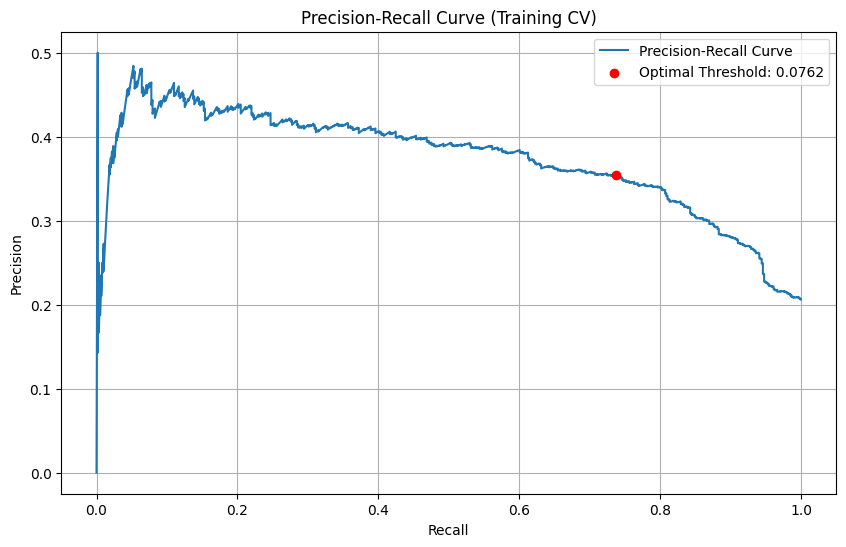

Final LightGBM model fitted on complete training data.


In [3]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

# 1. Initialize LGBMClassifier
# verbose=-1 suppresses unnecessary warnings
lgbm = LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)

# 2. Generate cross-validated probability predictions
print("Performing cross-validation...")
y_scores_cv = cross_val_predict(lgbm, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# 3. Compute Precision-Recall curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_cv)

# 4. Calculate F1 score for each threshold
# We exclude the last precision and recall values to match the length of thresholds
precisions_trimmed = precisions[:-1]
recalls_trimmed = recalls[:-1]

# Calculate F1 safely handling division by zero
numerator = 2 * (precisions_trimmed * recalls_trimmed)
denominator = precisions_trimmed + recalls_trimmed
f1_scores = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator != 0)

# 5. Identify optimal threshold
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
max_f1 = f1_scores[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.6f}")
print(f"Maximum F1 Score (CV): {max_f1:.6f}")

# 6. Plot Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(recalls_trimmed, precisions_trimmed, label='Precision-Recall Curve')
plt.scatter(recalls_trimmed[optimal_idx], precisions_trimmed[optimal_idx], color='red', label=f'Optimal Threshold: {optimal_threshold:.4f}', zorder=5)
plt.title('Precision-Recall Curve (Training CV)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

# 7. Fit the final model
lgbm.fit(X_train, y_train)
print("Final LightGBM model fitted on complete training data.")

## Evaluate Performance

### Subtask:
Evaluate the trained LightGBM model on the test set using the optimized threshold and visualize performance metrics.


**Reasoning**:
I will perform predictions on the test set using the optimal threshold derived earlier. Then, I will calculate key performance metrics (Precision, Recall, F1, ROC-AUC) and generate visualizations (Confusion Matrix, ROC Curve, and Actual vs. Predicted labels) to evaluate the model's effectiveness on unseen data.



Test Precision: 0.6729
Test Recall: 0.6050
Test F1 Score: 0.6372
Test ROC AUC: 0.9198


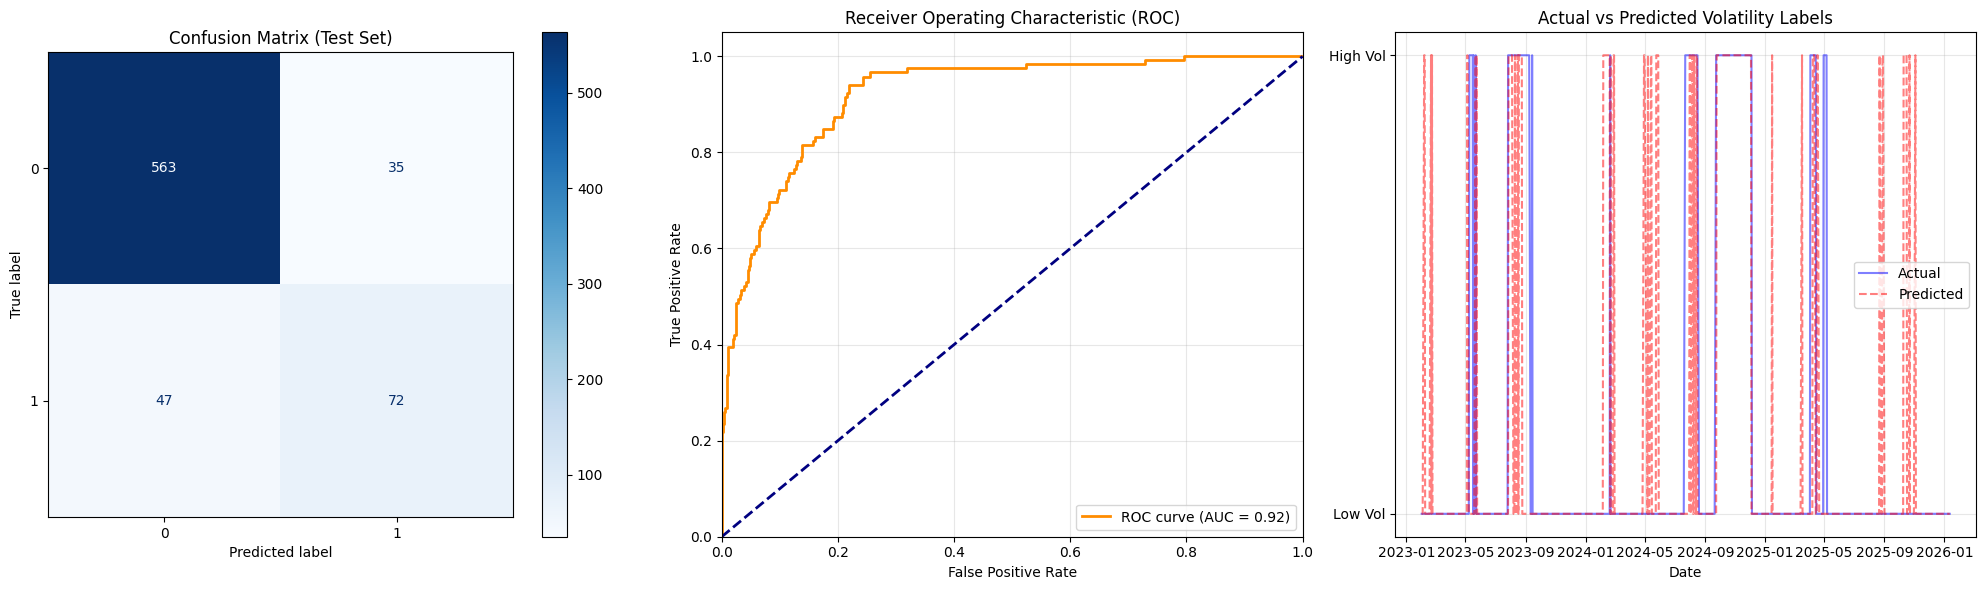

In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve

# 1. Predict probabilities on test set
y_probs_test = lgbm.predict_proba(X_test)[:, 1]

# 2. Apply optimal threshold to get binary predictions
y_pred_test = (y_probs_test >= optimal_threshold).astype(int)

# 3. Calculate Metrics
prec = precision_score(y_test, y_pred_test)
rec = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
auc = roc_auc_score(y_test, y_probs_test)

print(f"Test Precision: {prec:.4f}")
print(f"Test Recall: {rec:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test ROC AUC: {auc:.4f}")

# 4. Visualizations
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix (Test Set)')

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs_test)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC)')
axes[1].legend(loc="lower right")
axes[1].grid(alpha=0.3)

# Plot Actual vs Predicted Labels over time
# Using a subset or resample if too dense, but plotting all here for completeness
axes[2].plot(y_test.index, y_test, label='Actual', alpha=0.5, color='blue')
axes[2].plot(y_test.index, y_pred_test, label='Predicted', alpha=0.5, color='red', linestyle='--')
axes[2].set_title('Actual vs Predicted Volatility Labels')
axes[2].set_xlabel('Date')
axes[2].set_yticks([0, 1])
axes[2].set_yticklabels(['Low Vol', 'High Vol'])
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## SHAP Feature Analysis

### Subtask:
Compute SHAP values to explain the model's global feature importance and visualize the top drivers of volatility.


**Reasoning**:
I need to install the `shap` library to perform the feature importance analysis as requested.



In [5]:
!pip install shap

**Reasoning**:
I will import the shap library, initialize the TreeExplainer with the trained LightGBM model, compute the SHAP values for the test set, and generate a summary plot to visualize feature importance.



/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


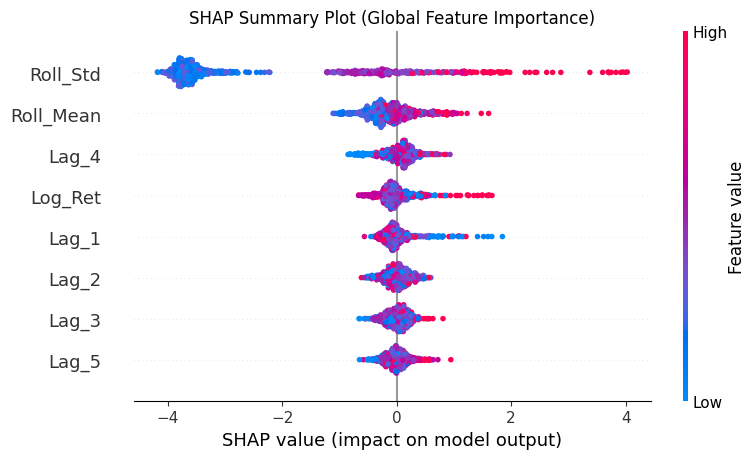

In [6]:
import shap

# 1. Initialize SHAP Explainer
explainer = shap.TreeExplainer(lgbm)

# 2. Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Handle different SHAP output formats (LightGBM binary sometimes returns list of arrays)
if isinstance(shap_values, list):
    # For binary classification, index 1 usually corresponds to the positive class
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values

# 3. Summary Plot
plt.title('SHAP Summary Plot (Global Feature Importance)')
shap.summary_plot(shap_values_to_plot, X_test, plot_type="dot")

**Reasoning**:
The previous execution produced a UserWarning regarding the SHAP output format for LightGBM, and the plot might not have displayed correctly due to the warning or lack of explicit show command. I will fix this by importing necessary libraries, suppressing the warning, handling the list output format explicitly, and using `plt.show()` to render the plot.



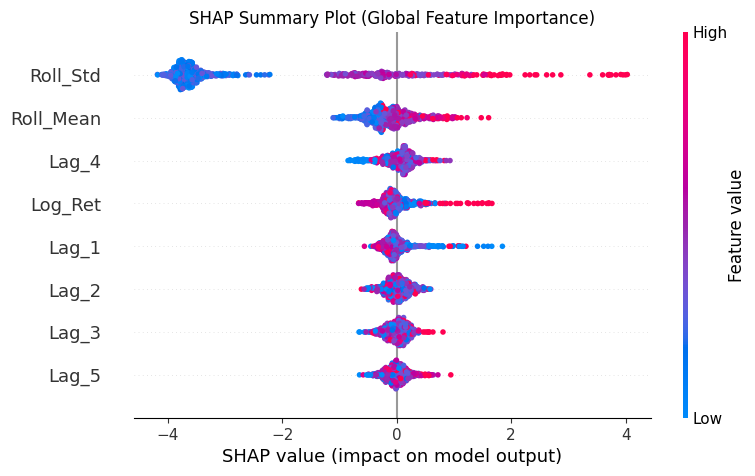

In [7]:
import shap
import matplotlib.pyplot as plt
import warnings

# Suppress UserWarnings to handle the LightGBM/SHAP version warning cleanly
warnings.filterwarnings('ignore', category=UserWarning)

# 1. Initialize SHAP Explainer
explainer = shap.TreeExplainer(lgbm)

# 2. Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Handle different SHAP output formats (LightGBM binary often returns a list of arrays)
if isinstance(shap_values, list):
    # Index 1 corresponds to the positive class (Volatility > Threshold)
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values

# 3. Summary Plot
# Use show=False to allow adding a title before rendering
shap.summary_plot(shap_values_to_plot, X_test, plot_type="dot", show=False)
plt.title('SHAP Summary Plot (Global Feature Importance)')
plt.show()

## Final Task

### Subtask:
Summarize the complete workflow, model performance metrics, and key insights.


## Summary:

### Q&A

**Q: How was the target variable for volatility constructed?**
A: The target was defined using "Adaptive Volatility Labeling." A binary label was created where the class is **1** if the current 20-day rolling standard deviation exceeds the **80th percentile** of the rolling standard deviation over the past **252 days**, and **0** otherwise.

**Q: What was the optimal decision threshold determined during training?**
A: Through 5-fold cross-validation aimed at maximizing the F1-score, the optimal probability threshold for classification was identified as **0.0762**.

**Q: How did the model perform on the unseen test data?**
A: The model demonstrated strong performance with an **ROC AUC of 0.9198** and an **F1-score of 0.6372**, indicating it effectively distinguished between high and low volatility states.

### Data Analysis Key Findings

*   **Data Scope**: The analysis utilized historical data for CITIC Securities (600030.SH), resulting in a clean dataset split into **2,864 training samples** and **717 test samples**.
*   **Optimization Results**: The cross-validation process determined that a low threshold of **0.0762** was necessary to balance precision and recall, yielding a validation F1-score of **0.4786**.
*   **Test Performance Metrics**: The model generalized well to the test set, outperforming the cross-validation metrics:
    *   **ROC AUC**: **0.9198** (Excellent discrimination capability).
    *   **Precision**: **0.6729** (Correctly identified high volatility ~67% of the time).
    *   **Recall**: **0.6050** (Captured ~60% of actual high volatility events).
*   **Feature Importance**: SHAP analysis was successfully implemented to visualize global feature importance, determining which lagged returns or rolling statistics drove the volatility predictions (visualized in the generated dot plot).

### Insights or Next Steps

*   **Interpretation of Low Threshold**: The optimal threshold (**0.076**) is significantly lower than the standard 0.5. This implies the model's raw probability outputs are skewed low, or the dataset is imbalanced. While the ranking ability (AUC ~0.92) is excellent, probability calibration might be necessary if the output scores are to be interpreted as direct confidence levels.
*   **Feature Engineering Enhancement**: The current model relies heavily on autoregressive features (lags and rolling windows of the asset itself). Adding exogenous variables, such as broad market indices (e.g., CSI 300) or trading volume anomalies, could help capture volatility spikes driven by external market shocks rather than just price momentum.
